In [1]:
import numpy as np
import pandas as pd

import itertools
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures

from matplotlib import pyplot as plt
import matplotlib.animation as animation
import seaborn
%matplotlib inline

In [2]:
class Perceptron(object):
    def __init__(self, learning_rate, max_iter = 1000):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
    
    def predict(self, X):
        X = np.hstack([np.ones((X.shape[0], 1)), np.array(X)])
        return np.array([self._predict_one(v) for v in X])
    
    def _predict_one(self, x):
        return int(np.dot(self.weights.T, x) >= 0)
    
    def fit(self, X, y, verbose = False):
        X = np.hstack([np.ones((X.shape[0], 1)), np.array(X)])
        y = np.array(y)
        
        n = X.shape[0]
        
        if self.max_iter < n:
            self.max_iter = n
                   
        self.weights = np.random.normal(size=X.shape[1])
        
        best_weights = self.weights.copy()
        best_score = 0.
        
        for i in range(self.max_iter):
            idx = i % n
            pred = self._predict_one(X[idx])
            if pred != y[idx]:
                if pred == 0:
                    self.weights += self.learning_rate*X[idx]
                else:
                    self.weights -= self.learning_rate*X[idx]
                    
            cur_score = accuracy_score(y, [self._predict_one(v) for v in X])
                
            if cur_score > best_score:
                best_score = cur_score
                best_weights = self.weights.copy()
                
            if verbose and i % (self.max_iter/10) == 0:
                print 'iteration: {}, accuracy:{}'.format(i, best_score)
        
        if verbose:
            print 'best score: {}'.format(best_score)
            print 'best weights: {}'.format(best_weights)
            
        self.weights = best_weights
        return best_score

In [3]:
data = pd.read_csv('data/blobs2.csv')

In [4]:
X = data.drop(['label'], axis=1)
y = data['label']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75)

In [6]:
model = Perceptron(learning_rate=0.5, max_iter=10000)
model.fit(X_train, y_train, verbose = True)

iteration: 0, accuracy:0.516
iteration: 1000, accuracy:0.972
iteration: 2000, accuracy:0.981333333333
iteration: 3000, accuracy:0.981333333333
iteration: 4000, accuracy:0.981333333333
iteration: 5000, accuracy:0.984
iteration: 6000, accuracy:0.984
iteration: 7000, accuracy:0.984
iteration: 8000, accuracy:0.984
iteration: 9000, accuracy:0.984
best score: 0.984
best weights: [ 11.70282895   0.48301462  -4.5326863 ]


0.98399999999999999

In [7]:
preds = model.predict(X_test)
print accuracy_score(y_test, preds)

0.988


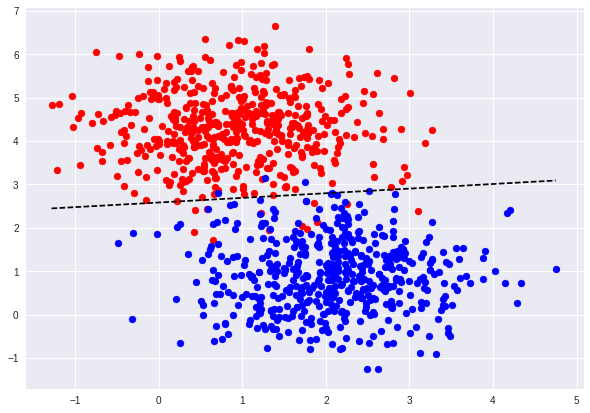

In [8]:
plt.figure(figsize=(10, 7))
plt.scatter(data[data['label'] == 0]['x'], data[data['label'] == 0]['y'], color='red')
plt.scatter(data[data['label'] == 1]['x'], data[data['label'] == 1]['y'], color='blue')
a, b = -model.weights[1]/model.weights[2], -model.weights[0]/model.weights[2]
l = np.linspace(np.min(data['x']), np.max(data['x']))
plt.plot(l, a*l+b, 'k--')

In [9]:
def plot_polynomial(X_orig, y_train, k):
    x_min, x_max = np.min(X_orig['x']) - 1, np.max(X_orig['x']) + 1
    y_min, y_max = np.min(X_orig['y']) - 1, np.max(X_orig['y']) + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.025),
                         np.arange(y_min, y_max, 0.025))
    
    X_test = np.c_[xx.ravel(), yy.ravel()]
    
    poly = PolynomialFeatures(degree=k)
    X_train = poly.fit_transform(X_orig)
    X_test = poly.transform(X_test)
    
    model = Perceptron(learning_rate=0.5)
    score = model.fit(X_train, y_train)
    Z = model.predict(X_test)
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(10, 7))
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X_orig[y_train == 0]['x'], X_orig[y_train == 0]['y'], color='red')
    plt.scatter(X_orig[y_train == 1]['x'], X_orig[y_train == 1]['y'], color='blue')
    plt.title('degree: {}, accuracy: {}'.format(k, score))
    
    print 'model weights: {}'.format(model.weights)
        

model weights: [  8.59484158   9.53276981  10.79682248  16.78877369  10.64332312
  10.88541636  17.62809485  18.526192     0.94968868 -11.39468463
 -13.50059362]


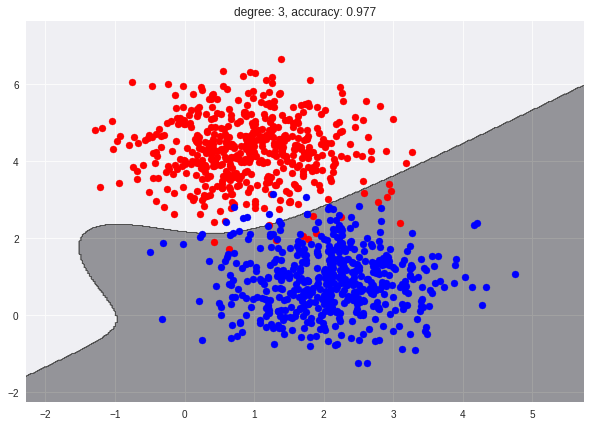

In [10]:
plot_polynomial(X, y, 3)

model weights: [ 20.12733966  20.29728678  21.09647321  38.23954048  30.06009309
  37.01977945  65.27241378  48.18665832  39.87581074  44.5483405
  81.74337645  91.81739801  29.12853879  -7.60906349 -35.12270306
 -54.33877991]


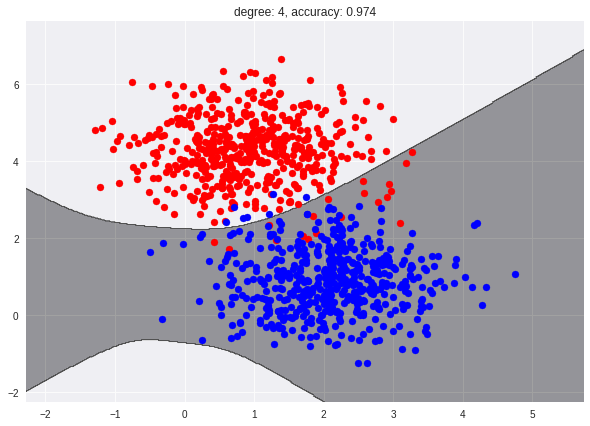

In [11]:
plot_polynomial(X, y, 4)

model weights: [   29.95120279    30.83733578    37.3107709     55.72798794    59.54494939
    71.17028453   105.58851303   112.46090407   121.69616163   145.68747933
   178.16659959   237.93928446   225.31448866   254.32059127   279.61920348
   115.49895336   556.75484698   458.5655098    469.13785634   518.38240191
   368.27982947 -1357.71426501]


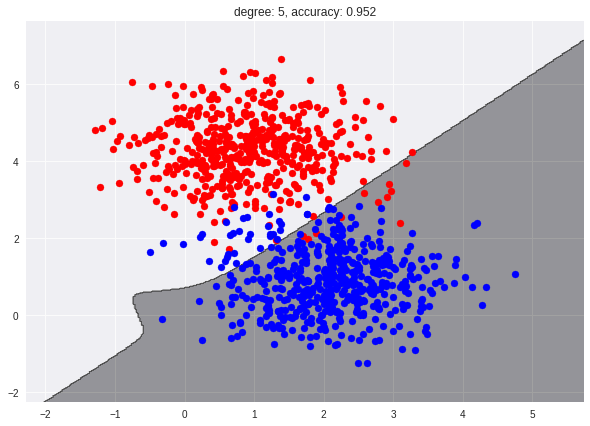

In [12]:
plot_polynomial(X, y, 5)